# Исследование рынка недвижимости в Петербурге и области

Имеются данные - архив объявлений о продаже недвижимости в Петербурге и соседних населённых пунктах за последние несколько лет. Наша задача - определить факторы, наиболее сильно влияющие на рыночную стоимость объектов недвижимости. Нужно установить параметры, которые позволят построить автоматизированную систему, которая будет отслеживать аномалии и мошенническую деятельность. 

Каждый объект недвижимости в датасете имеет различные данные - такие как этаж, цена, площадь, дата размещения объявления. Часть данных вписана вручную пользователями, Вторая часть получена автоматически на основе картографических данных. например, такие данные как, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Изучение данных из файла

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')#файл изучен, определён разделитель данных "\t"
data.info()#посмотрим данные датафрейма
data.head()#изучим общий вид таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

Файл открыт и изучен. В этой базе данных представлены параметры обьектов недвижимости из объявлений - от цены, площади, количества комнат до близости парков, центра и прочего. Данные имеют разные типы - строковые, булевы, числовые. Из изученных первых строк уже видно, что есть пропуски в данных. В любом случае вначале нужно произести предобработку.

## Предобработка данных

Во-первых, у нас имеются пропуски в столбце 'ceiling_height' - высота потолков. Так как высота потоклов не зависит ни от какого другого данного нам параметра жилья (у нас нет стоблца год постройки или тип дома), то имеет смысл либо оставить данные пропуски, либо заполнить медианой по всем указанным данным.

In [2]:
data['ceiling_height'].describe()#изучаем столбец с длиной потолков

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [3]:
print('Медианная длина потолка:', data['ceiling_height'].median())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].isna().sum()

Медианная длина потолка: 2.65


0

Медиана совпадает со стандартной длиной потолка в России, также имеются явно аномальные значения, с ними будем работать позже.

In [4]:
data.groupby('studio')['rooms'].value_counts()

studio  rooms
False   1        8036
        2        7940
        3        5814
        4        1180
        5         326
        6         105
        0          59
        7          59
        8          12
        9           8
        10          3
        11          2
        14          2
        12          1
        15          1
        16          1
        19          1
True    0         138
        1          11
Name: rooms, dtype: int64

У нас имеются обьекты недвижимости с количеством комнат 0 - большая часть это студии, но есть и нестудии с нулевым количеством комнат. То что данные ошибочны, уверенности нет, и заменять данное значение на какое-либо ещё смысла не вижу.
У нас также имеются пропуски в столбце living_area - то есть жилая площадь. Высчитать значение жилой площади исходя из данных общей площади, или площади кухни считаю некорректно. Посмотрим медиану жилых площадей, в зависимости от количества комнат - наиболее зависящий параметр.

In [5]:
for rooms in data['rooms'].unique():
    median = data.loc[data['rooms']==rooms, 'living_area'].median()
    print(rooms, median) # будем выводить медианы жилплощади в зависимости от кол-ва комнат, чтобы проверить адекватность значений
    data.loc[(data['living_area'].isna())&(data['rooms']==rooms), 'living_area'] = median
print('Пропусков после замены: ', data['living_area'].isna().sum())

3 45.0
1 17.6
2 30.5
4 63.6
5 91.785
6 123.9
0 18.0
7 145.0
11 133.9
8 161.0
14 195.15
10 161.4
15 409.0
9 179.2
19 264.5
16 180.0
12 409.7
Пропусков после замены:  0


In [6]:
print(data.groupby(['rooms','studio'])['kitchen_area'].median())

rooms  studio
0      False        NaN
       True         NaN
1      False       9.04
       True         NaN
2      False       8.80
3      False       9.50
4      False      11.10
5      False      15.10
6      False      19.50
7      False      20.00
8      False      25.00
9      False      14.30
10     False      19.80
11     False      12.60
12     False     112.00
14     False      21.25
15     False     100.00
16     False      13.00
19     False      27.60
Name: kitchen_area, dtype: float64


Изучив столбец "Площадь кухни", видим, что в объектах недвижимости с нулевым количеством комнат нет и кухонь - видимо это комнаты, а не квартиры. Также видим что площади кухни не указаны у квартир-студий. Можно заменить пропуски у комнат и студий значением 0, а у остальных - медианой в зависимости от кол-ва комнат.

In [7]:
for i in range(len(data)):
    if data.loc[i, 'studio']==True or data.loc[i, 'rooms']==0:
        data.loc[i, 'kitchen_area'] = 0
for rooms in data['rooms'].unique():
    median = data.loc[data['rooms']==rooms, 'kitchen_area'].median()
    print(rooms, median) # будем выводить медианы жилплощади в зависимости от кол-ва комнат, чтобы проверить адекватность значений
    data.loc[(data['kitchen_area'].isna())&(data['rooms']==rooms), 'kitchen_area'] = median
print('Пропусков после замены: ', data['kitchen_area'].isna().sum())

3 9.5
1 9.0
2 8.8
4 11.1
5 15.1
6 19.5
0 0.0
7 20.0
11 12.600000000000001
8 25.0
14 21.25
10 19.8
15 100.0
9 14.3
19 27.6
16 13.0
12 112.0
Пропусков после замены:  0


In [8]:
print(data.groupby('ponds_around3000')['ponds_nearest'].count())
print(data.groupby('parks_around3000')['parks_nearest'].count())

ponds_around3000
0.0       0
1.0    5717
2.0    1892
3.0    1501
Name: ponds_nearest, dtype: int64
parks_around3000
0.0       4
1.0    5681
2.0    1747
3.0     647
Name: parks_nearest, dtype: int64


Изучив столбцы, связанные с парками и прудами, пришёл к выводу, что заменять пропущенные значения в них неуместно (медиана, среднее или распространённое значение здесь по логике не подойдёт).

Далее столбец 'is_apartment' - заполнено очень мало строк. Осмелюсь предположить, что там где данные пропущены, объекты апартаментами не являются, так как владельцы апартаментов скорее всего указали этот тип, а не пропустили при заполнении.

In [9]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

In [10]:
print(data['balcony'].isna().sum())
data['balcony'].describe()

11519


count    12180.000000
mean         1.150082
std          1.071300
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

Проанализировав столбец с количеством балконов, я принял решение заменить пропуски здесь нулевым значением - скорее всего если балкон не указан, значит его нет.

In [11]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

In [12]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [13]:
data = data.dropna(subset=['locality_name']) # избавляемся от строк с пустыми значениями.
data['locality_name'].isna().sum()

0

Теперь приведём в порядок строки с населёнными пунктами - оставим только названия.

In [14]:
removal_list = ['садовое','садоводческое', 'некоммерческое', 'коттеджный', 'товарищество', 'посёлок', 'поселок', 'городского', 'типа', 'деревня', 'станции', 'городской', 'село']
def remove_word(string):
    words = string.split(' ') #разделение строки на слова для поиска
    final_list = [word for word in words if word not in removal_list] #условие для объединения, исключающая слова из списка типов населённых пунктов.
    final_string = ' '.join(final_list)
    return final_string

data['locality_name'] = data['locality_name'].apply(remove_word)

In [15]:
data['locality_name'].unique()#проверяем результат

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Теперь переведём данные столбца first_day_exposition в формат стандартный формат даты (без времени, так как оно здесь не требуется)

In [16]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
data.head()#проверка результата

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,...,11.0,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,45.0,9,False,...,9.5,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Пропуски в столбце с расстоянием до центра или аэропорта заполнить не могу - так как высчитать эти данные возможности нет, а заполнить медианой это некорректно. Отбрасывать сейчас такой большой массив данных тоже не будем - он может повлиять на наше исследование.
Пропуски в столбце 'days_exposition' могут означать, что обьявление было опубликовано, но ещё не снято. Это значит, недвижимость не была реализована на данный момент за ту цену, которая указана. Будем учитывать этот факт в дальнейшем.
Необходимо округлить данные для более точного последующего анализа.

### Вывод
Обнаружил и обработал пропуски в данных там, где это уместно. В некоторых столбцах заполнять пропуски высчитанными или медианными значениями некорректно - их я оставил как есть. Исправил строки с наименованием населённых пунктов. Поменял тип данных у столбца с датой объявления.

## Расчёты и добавление результатов в таблицу

Посчитаем и добавим в таблицу колонки:
1. Цена квадратного метра 'psm_price'
2. День недели публикации объявления 'week_day_exposition'
3. Месяц публикации объявления 'month_exposition'
4. Год публикации объявления 'year_exposition'
3. Этаж квартиры; варианты — первый, последний, другой 
4. Соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [17]:
data['psm_price'] = data['last_price'] / data['total_area'] #цена кв. метра - отношение цены за обьект к его площади
data['psm_price'] = pd.to_numeric(data['psm_price'],errors = 'coerce')
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

def flooration(row): #функция для столбца с типом этажа - первый, последний, другой.
    if row['floor'] == 1: return 'первый'
    if row['floor'] == row['floors_total']: return 'последний'
    return 'другой'
data['floor_type'] = data.apply(flooration, axis = 1) #применяем новую функцию для создания нового столбца

data['living_ratio'] = data['living_area'] / data['total_area'] #добавляем соотношение жилой и общей площади
data['kitchen_ratio'] = data['kitchen_area'] / data['total_area'] # отношение площади кухни к общей площади

display(
    data.loc[200:209, ['last_price', 'total_area',
                       'living_ratio', 'kitchen_ratio',
                       'psm_price', 'weekday_exposition', 
                       'month_exposition', 'year_exposition',
                      'floor', 'floors_total', 'floor_type']]
) # проверим корректность столбцов

,last_price,total_area,living_ratio,kitchen_ratio,psm_price,weekday_exposition,month_exposition,year_exposition,floor,floors_total,floor_type
200,9150000.0,98.3,0.613428,0.127162,93082.400814,5,6,2018,11,13.0,другой
201,10880000.0,123.1,0.722989,0.089358,88383.428107,3,11,2015,2,5.0,другой
202,4700000.0,67.0,0.647761,0.131343,70149.253731,5,4,2017,1,9.0,первый
203,3999000.0,34.1,0.424340,0.304985,117272.727273,4,11,2016,12,25.0,другой
204,3600000.0,44.2,0.610860,0.142534,81447.963801,4,1,2018,3,9.0,другой
205,1980000.0,30.6,0.568627,0.186275,64705.882353,0,1,2018,4,5.0,другой
206,5080000.0,31.3,0.511182,0.242812,162300.319489,1,4,2019,4,7.0,другой
207,9000000.0,72.6,0.595041,0.157025,123966.942149,5,9,2018,4,5.0,другой
208,2450000.0,42.5,0.404706,0.197647,57647.058824,2,4,2019,5,5.0,последний
209,4700000.0,45.0,0.608889,0.191111,104444.444444,3,4,2019,4,9.0,другой


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

### Вывод
Расчёты произведены, данные добавлены в таблицу.

## Исследовательский анализ данных

Изучим такие параметры недвижимости, как площадь, количество комнат, высота потолков, цена. Построим гистограммы.

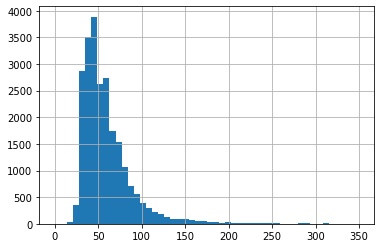

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

In [19]:
data['total_area'].hist(bins=50, range=(0, 350))
plt.show()
data['total_area'].describe()

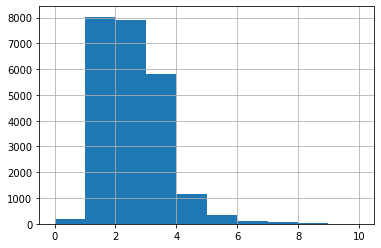

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [20]:
data['rooms'].hist(bins=10, range=(0, 10))
plt.show()
data['rooms'].describe()

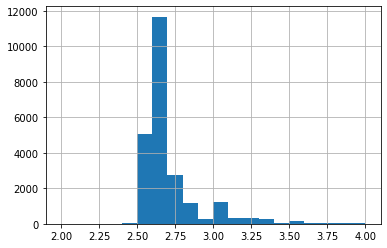

count    23650.000000
mean         2.724311
std          0.989255
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [21]:
data['ceiling_height'].hist(bins=20, range=(2, 4))
plt.show()
data['ceiling_height'].describe()

Для анализа цен на жильё создадим столбец с ценами в тысячах рублей, чтобы цифры отображались корректно.

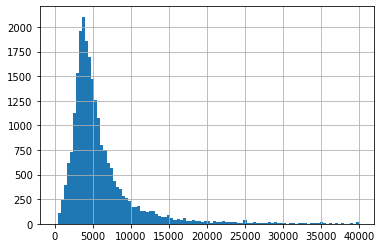

count     23650.000000
mean       6541.126898
std       10896.399175
min          12.190000
25%        3400.000000
50%        4650.000000
75%        6799.000000
max      763000.000000
Name: last_price_k, dtype: float64

In [22]:
data['last_price_k'] = data['last_price'] / 1000
data['last_price_k'].hist(bins=100, range=(0, 40000))
plt.show()
data['last_price_k'].describe()

В базе данных представлены квартиры площадью от 12 до 900 кв. м, средняя площадь 60, а медиана - 52 квадратных метров. Распределение по графику нормальное.
Цены на недвижимость варьируются от 1.2 млн до 763 млн - выбивающиеся значения сильно влияют на среднее значение 6,5 млн., тогда как медиана - всего 4,6 млн.
Больше всего однокомнатных квартир. Также много двух- и трёхкомнатных. Есть и дворцы с 19 комнатами - максимальное значение.
Высота потолков в среднем составляет 2,77 м, медиана 2,65 м.

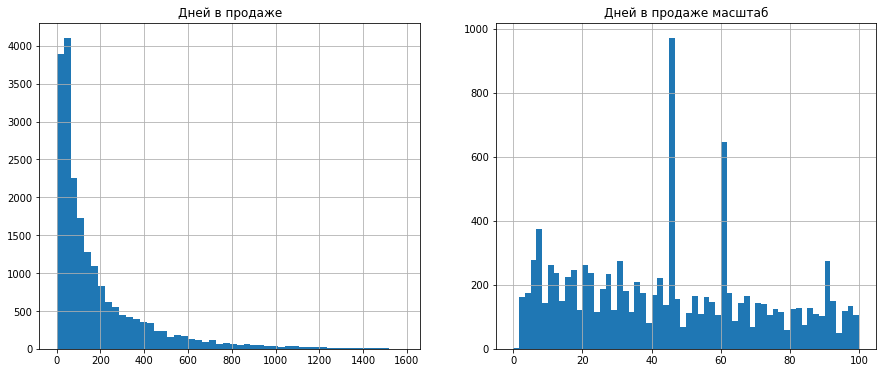

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [23]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

data['days_exposition'].hist(bins=50, ax=axes[0])
axes[0].set_title('Дней в продаже')

data['days_exposition'].hist(bins=60, range=(0,100), ax=axes[1])
axes[1].set_title('Дней в продаже масштаб')
plt.show()
data['days_exposition'].describe()

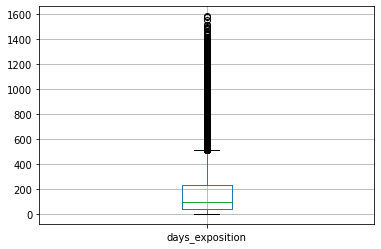

In [24]:
data.boxplot('days_exposition') #смотрим диаграмму размаха
plt.show()

Изучил гистограммы. Вижу, что есть пики в районе 7, 30, 45 и 60 дней. Есть предположение, что это связано с особенностями размещения объявления на площадке - возможно, приходит напоминание о снятии реализованного обьекта с обьявления, или он снимается сам без активности. Хотя некоторая часть действительно была продана в эти значения, стоит избавится хотя бы от сильно выбивающихся значений 45 и 60 - они сильно влияют на выборку.

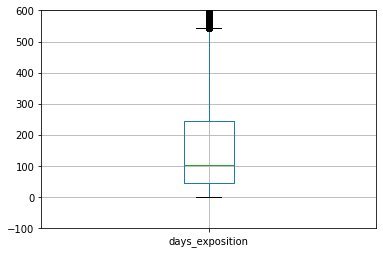

count    19490.000000
mean       187.781426
std        222.877194
min          1.000000
25%         45.000000
50%        104.000000
75%        244.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [25]:
good_data = data.query('days_exposition not in (7, 30, 45, 60)')#очищаем аномальные значения и очищенные данные помещаем в новый датафрейм
plt.ylim(-100, 600)
good_data.boxplot('days_exposition')
plt.show()
display(good_data['days_exposition'].describe())

Очистив от сильно выбирвающихся значений мы видим, что медиана и среднее значение изменились - теперь это 112 и 194 дня соответственно. Диаграмма размаха тоже изменилась, усы сместились. Теперь нормальные значения располагаются от 1 до 572 дней.

Теперь очистим данные от редких значений.

In [26]:
good_data = good_data.query('(days_exposition < 572) | days_exposition.isnull()') #очищаем от редких значений дни продажи
good_data = good_data.query('2 < ceiling_height < 3.5') #очищаем от редких значений длину потолков
good_data = good_data.query('total_area < 250') #общая площадь
good_data = good_data.query('rooms < 9') #комнаты
good_data = good_data.query('last_price_k < 15000') #цена в тыс. рублей.

Посмотрим, какие факторы больше всего влияют на стоимость квартиры. Исследуем, зависит ли цена за квадратный метр от площади, числа комнат, удалённости от центра, а также зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. И влияние даты размещения: дня недели, месяца и года.

-0.005835127224713413

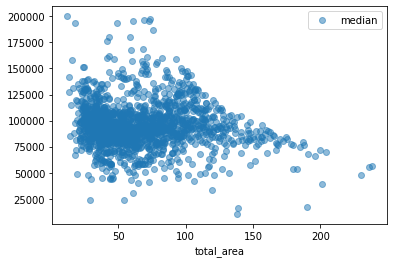

In [27]:
pivot_area = good_data.pivot_table(index = 'total_area', values = 'psm_price', aggfunc = ['count', 'mean', 'median'])
pivot_area.columns = ['count', 'mean', 'median']#создали сводную таблицу цены за кв. м. от площади недвижимости
pivot_area.plot(y = 'median', style = 'o', alpha = 0.5)#строим график
good_data['total_area'].corr(data['psm_price'])#найдём корреляцию Пирсона

Верхний правый угол графика пуст - у объектов с очень большой площадью цена за кв. метр в целом ниже. Если брать обычные обьекты, менее 110 кв. метров - то здесь распределение ровное - и корреляция пропадает. 

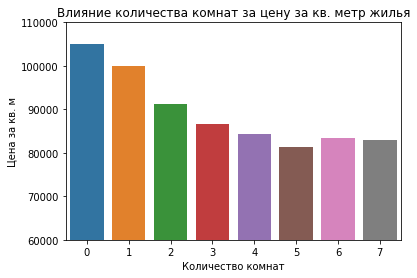

In [28]:
#строим график влияния количества комнат за цену за кв. метр жилья
sns.barplot(x = 'rooms', y = 'psm_price', data = (good_data.groupby('rooms', as_index=False)['psm_price'].median()))
plt.xlabel('Количество комнат')
plt.ylabel('Цена за кв. м')
plt.title('Влияние количества комнат за цену за кв. метр жилья')
plt.ylim(60000, 110000)
plt.show()

Здесь мы видим отрицательную корреляцию - с увеличением количества комнат снижается цена за квадратный метр.

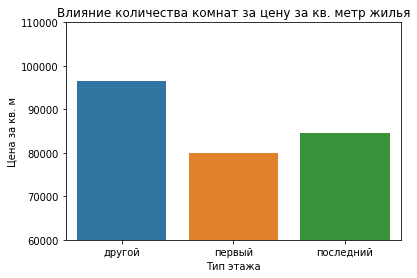

In [29]:
#строим график влияния типа этажа на цену жилья
sns.barplot(x = 'floor_type', y = 'psm_price', data = (good_data.groupby('floor_type', as_index=False)['psm_price'].median()))
plt.xlabel('Тип этажа')
plt.ylabel('Цена за кв. м')
plt.title('Влияние количества комнат за цену за кв. метр жилья')
plt.ylim(60000, 110000)
plt.show()

Здесь зависимость следующая - первый этиж ценится меньше всего, но и последний немногим лучше. Больше всего спрос и цена на остальные этажи.

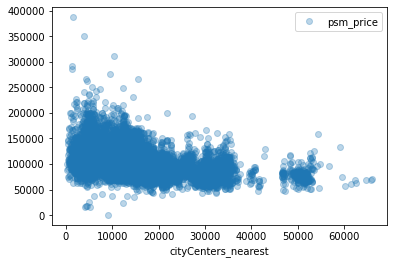

In [30]:
good_data.plot(y = 'psm_price', x = 'cityCenters_nearest',style = 'o', alpha = 0.3)
#смотрим зависимость цены за кв. м. от близости к центру.
plt.show()

Здесь видно, что расстояние до центра влияет на цену, но близость к центру не всегда делает обьект дороже - здесь есть ещё много факторов. 

(85000.0, 100000.0)

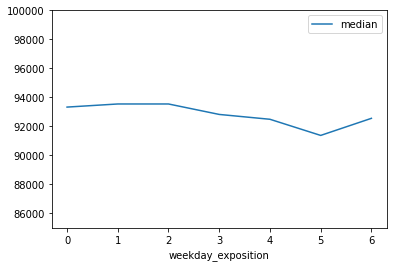

In [31]:
pivot_weekday = good_data.pivot_table(index = 'weekday_exposition', values = 'psm_price', aggfunc = ['count', 'mean', 'median'])
pivot_weekday.columns = ['count', 'mean', 'median']#создали сводную таблицу цены за кв. м. дня недели размещения объявления
pivot_weekday.plot(y = 'median')#строим график
plt.ylim(85000, 100000)

Здесь зависимость несущественна - медиана цены за квадратный метр примерно одна на протяжении всех дней недели рамещения объявления. Самое низкое значение - это суббота. Скорее всего это связано с тем, что это выходные, значит здесь больше обьявлений от обычных людей, не связанных с агенствами и прочим.

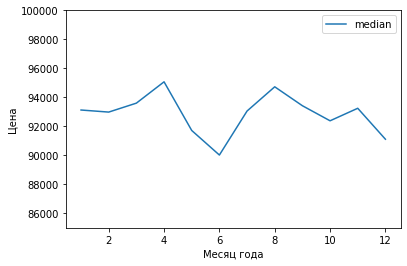

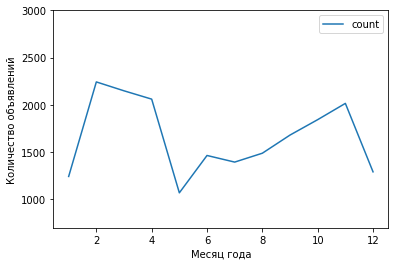

In [32]:
pivot_month = good_data.pivot_table(index = 'month_exposition', values = 'psm_price', aggfunc = ['count', 'mean', 'median'])
pivot_month.columns = ['count', 'mean', 'median']#создали сводную таблицу цены за кв. м. от месяца размещения объявления
pivot_month.plot(y = 'median')#строим график
plt.ylim(85000, 100000)
plt.xlabel('Месяц года')
plt.ylabel('Цена')
pivot_month.plot(y = 'count')
plt.ylim(700, 3000)
plt.xlabel('Месяц года')
plt.ylabel('Количество объявлений')
plt.show()

Что можно увидеть, посмотрев на графики медианной цены и количества размещённых объявлений в заивсимости от месяца размещения?
1. Декабрь и январь - низкая активность по недвижимости, средняя цена за квадратный метр в декабре на порядок ниже - к концу года люди явно снижают цены, чтобы побыстрее найти покупателя.
2. Конец весны и начало лета - тоже снижение по количеству объявлений, и цена самая низкая, скорее причина в дачном сезоне и отпусках.

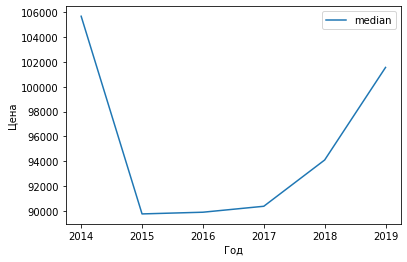

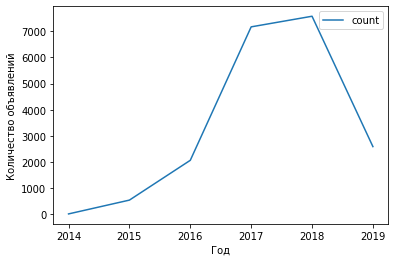

In [33]:
pivot_year = good_data.pivot_table(index = 'year_exposition', values = 'psm_price', aggfunc = ['count', 'mean', 'median'])
pivot_year.columns = ['count', 'mean', 'median']#создали сводную таблицу цены за кв. м. от года размещения объявления
pivot_year.plot(y = 'median')
plt.xlabel('Год')
plt.ylabel('Цена')#строим график
pivot_year.plot(y = 'count')
plt.xlabel('Год')
plt.ylabel('Количество объявлений')
plt.show()

2014 год в расчёт здесь брать не будем - слишком малая выборка. В остальном: начиная с 2015 года цена за квадратный метр только растёт, что довольно предсказумо. Видно, что база данных ограничивается 2019 годом - даже его серединой, поэтому и количество объявлений за неполный год ниже.

Теперь необходимо выделить 10 населённых пунктов с наибольшим числом объявлений, посчитать среднюю цену квадратного метра в этих населённых пунктах.

In [34]:
locality_pivot = good_data.pivot_table(index='locality_name', values='psm_price', aggfunc =['count', 'mean'])
locality_pivot.columns = ['count', 'mean']
locality_pivot = locality_pivot.sort_values(by='count', ascending = False).head(10)
display(locality_pivot)

,count,mean
locality_name,,
Санкт-Петербург,12749,106870.531887
Мурино,543,86188.081472
Кудрово,421,95559.191643
Шушары,398,78614.598593
Всеволожск,357,66952.656577
Колпино,315,75310.038319
Пушкин,304,100857.254153
Парголово,299,89838.477686
Гатчина,273,68855.194079


Наиболее высокая цена за кв. метр ожидаемо в Санкт-Петербурге. Самая низкая стоимость метра в Выборге - как и самое маленькое количество предложений.

Теперь изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге и выясним, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах: округлите до целых значений. Посчитаем среднюю цену для каждого километра. Построим график зависимости цены от удалённости от центра. Определим границу, где график сильно меняется, — это и будет центральная зона.


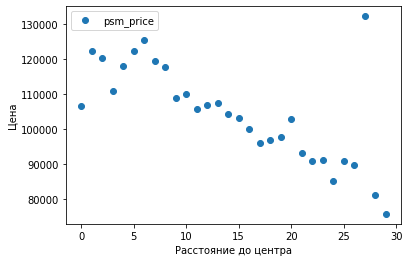

In [35]:
data_spb = good_data.query('locality_name == "Санкт-Петербург"')#создаём датафрейм для Питера
data_spb = data_spb.dropna(subset=['cityCenters_nearest'])#очищаем объекты, где не указано расстояние до центра
data_spb['center_km'] = (data_spb['cityCenters_nearest']/1000).round().astype(int)#округляем до километров
#data_spb[['center_km', 'cityCenters_nearest']] #проверяем результат
pivot_center_spb = data_spb.pivot_table(index='center_km', values='psm_price')
pivot_center_spb.plot(y = 'psm_price',style = 'o')#построим график зависимости цены от удалённости от центра.
plt.xlabel('Расстояние до центра')
plt.ylabel('Цена')
plt.show()

На графике видна прямая зависимость - чем ближе к центру в Петербурге - тем дороже в среднем квадратный метр жилья. График меняется на отметке 8 км до центра - это и будем считать центром Петербурга.

Выделим сегмент квартир в центре. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. 

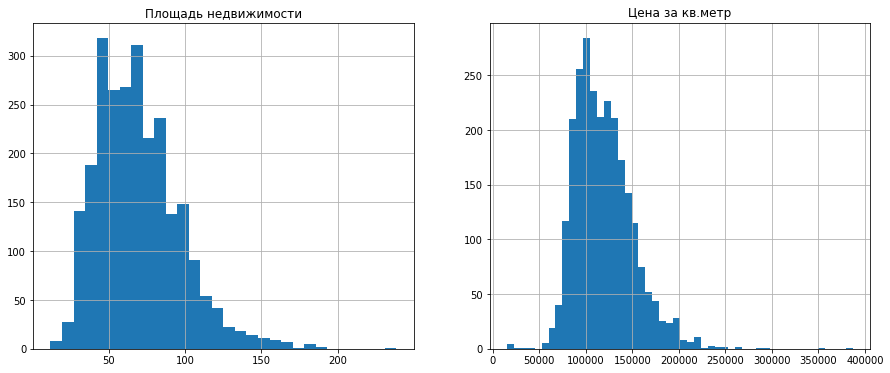

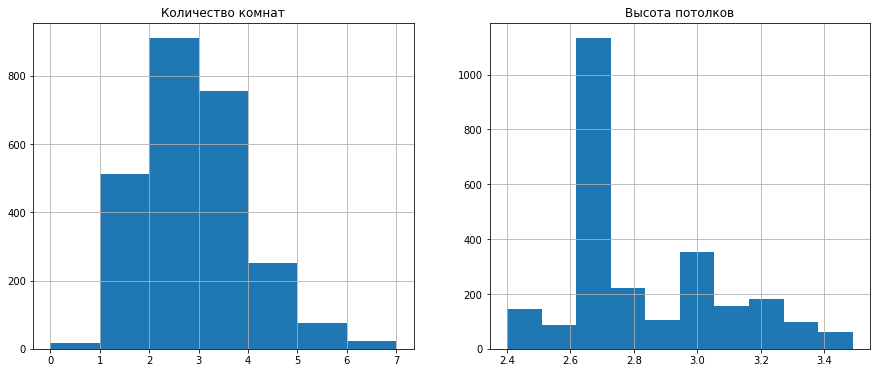

In [36]:
spb_center = data_spb[['psm_price', 'total_area', 'ceiling_height', 'rooms','center_km', 'first_day_exposition', 'floor_type']].query('center_km <=8')
#выведем 4 гистораммы с параметрами: площадь, цена, число комнат, высота потолков
fig, axes = plt.subplots(1,2,figsize=(15,6))

spb_center['total_area'].hist(bins=30, ax=axes[0])
axes[0].set_title('Площадь недвижимости')

spb_center['psm_price'].hist(bins=50, ax=axes[1])
axes[1].set_title('Цена за кв.метр')
plt.show()

fig, axes = plt.subplots(1,2,figsize=(15,6))

spb_center['rooms'].hist(bins=7, ax=axes[0])
axes[0].set_title('Количество комнат')

spb_center['ceiling_height'].hist(bins=10, ax=axes[1])
axes[1].set_title('Высота потолков')
plt.show()


Проанализировав данные гистограммы можно выделить некоторые отличительные особенности центра Петербурга от всей остальной территории:
1. Количество комнат здесь отличается - не так много квартир-студий, однокомнатных, зато двух- и трёхкомнатных больше.
2. Площадь квартир незначительно больше.

Выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления)

In [37]:
spb_center.groupby('rooms', as_index=False)['psm_price'].median()

,rooms,psm_price
0,0,133421.610169
1,1,136363.636364
2,2,120600.835518
3,3,105846.153846
4,4,96823.486797
5,5,87912.087912
6,6,85544.372924
7,7,89523.341523


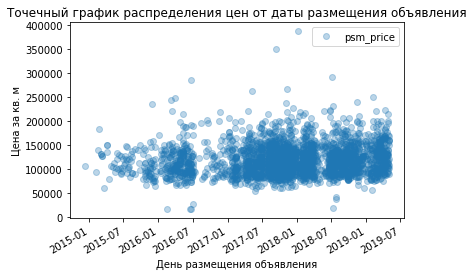

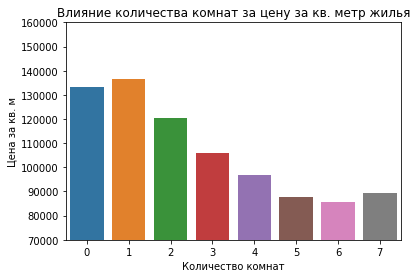

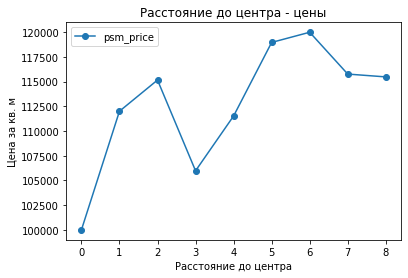

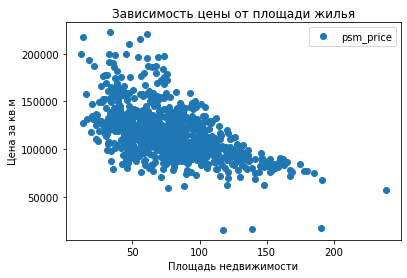

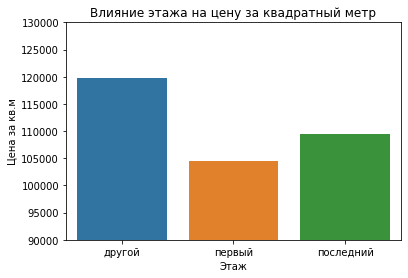

In [38]:
#построим 5 графиков для исследования
spb_center.plot(y='psm_price', x='first_day_exposition', style='o', alpha=0.3)
plt.xlabel('День размещения объявления')
plt.ylabel('Цена за кв. м')
plt.title('Точечный график распределения цен от даты размещения объявления')
plt.show()
sns.barplot(x = 'rooms', y = 'psm_price', data = (spb_center.groupby('rooms', as_index=False)['psm_price'].median()))
plt.xlabel('Количество комнат')
plt.ylabel('Цена за кв. м')
plt.title('Влияние количества комнат за цену за кв. метр жилья')
plt.ylim(70000, 160000)
plt.show()
#график цены от кол-ва комнат
spb_center.pivot_table(index='center_km', values='psm_price', aggfunc = ['median']).plot(y='median', style = 'o-')
plt.xlabel('Расстояние до центра')
plt.ylabel('Цена за кв. м')
plt.title('Расстояние до центра - цены')
plt.show()
#график цены от близости к центру
spb_center.pivot_table(index='total_area', values='psm_price', aggfunc = ['median']).plot(y='median', style = 'o')
plt.xlabel('Площадь недвижимости')
plt.ylabel('Цена за кв.м')
plt.title('Зависимость цены от площади жилья')
plt.show()
#график цены от площади
#spb_center.pivot_table(index='floor_type', values='psm_price', aggfunc = ['median'])
sns.barplot(x = 'floor_type', y = 'psm_price', data = (spb_center.groupby('floor_type', as_index=False)['psm_price'].median()))
plt.xlabel('Этаж')
plt.ylabel('Цена за кв.м')
plt.ylim(90000, 130000)
plt.title('Влияние этажа на цену за квадратный метр')
plt.show()#график цены от типа этажа

Главное отличие от предыдущего нашего анализа всех обьектов недвижимости - это то что в центре цена за квадратный метр изначально выше и не меняется сильно с годами.
Остальные факторы играют такую же роль на цену квадратного метра, как и для всего города. Единственное - ещё большая близость к центру уже не увеличивает цену квартиры.

## Общий вывод

В ходе данной работы я изучил полученную базу банных Яндекс.Недвижимости. Перед непосредственно исследованием была проведена работа по предобработке данных. Там, где это уместно, обработаны пропущенные значения, заменены типы данных в некоторых столбцах. Были высчитаны и добавлены в массив данных новые показазатели - цена за квадратный метр, категория этажа, год, месяц, день недели объявления.

С помощью графиков и гистограмм исследовал разные параметры квартир, преставленных на площадке. Обнаружил аномальные значения в ранзных параметрах. Для повышения точности анализа я избавился от выбросов и аномалий, очищенные данные были выделены в отдельный датафрейм.

В ходе исследования очищенных данных я обнаружил, что на цену за квадратный метр больше всего влияния оказывают такие параметры, как количество комнат, близость к центру, этаж (первый и последний этажи в среднем дешевле остальных вариантов).
Также предсказуемо увидел повышение цены за квадратный метр с годами.

Также я изучил центр Петербурга - с помощью графиков я определил его центр в радиусе восьми километров. Там цены уже не так сильно друг от друга отличаются. Квартиры здесь немногим больше по площади, и количество комнат в среднем тоже выше и практически нет студий или комнат. Цены за квадратный метр в центре города не так сильно растут с годами, но они здесь изначально были высоки и сейчас выше, чем в остальных частях города.
